In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph
%pip install -q -U langchain
%pip install -q -U langchain-google-genai

In [2]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=google_api_key,     # Provide the Google API key for authentication
)

In [4]:
from typing_extensions import TypedDict

class TextAnalysisState(TypedDict):
    text: str
    classification: str
    entities : str
    summary : str

In [52]:
# Node 1: Classification
def classification_node(state: TextAnalysisState) -> TextAnalysisState:
  print("--Classification--", state)
  text: str = state["text"]

  prompt: str = """
    You are given a Text as input.

    You need to categorize the text into one domain NEWS, ARTICLE, BLOG.

    Just return the Category i.e: for news classification then return NEWS.

    Text is: {text}
    """

  output = llm.invoke(prompt.format(text=text))

  return {"classification" : output.content}


In [33]:
# prompt: create a sample_state variable for TextAnalysisState

sample_state: TextAnalysisState = {
    "text": "This is a sample text as an article.",
}


In [9]:
output_node1 = classification_node(sample_state)
print(output_node1)

--Classification-- {'text': 'This is a sample text as an article.'}
{'classification': 'ARTICLE \n'}


In [53]:
# Node 2: Extraction
def entity_extraction_node(state: TextAnalysisState) -> TextAnalysisState:
  print("--Extraction--", state)
  text: str = state["text"]
  classification : str = state["classification"]


  prompt: str = """
   You are given a Text as input.

   You have to to extract the entities present in the text.
   Your job is to return just the names of the entites present in JSON i.e {{"entities": ["zia khan lives in karachi"]}}

   Text is: {text}

   Classification is: {classification}

   JSON OutPut Format: {{"entities": ["1"...]}}
   """

  output = llm.invoke(prompt.format(text=text, classification=classification))
  return{"entities" : output.content}

In [54]:
# prompt: Run above entity_extraction with samples

sample_state: TextAnalysisState = {
    "text": "This is a sample text about a news article.",
    "classification": "NEWS"
}

node_2_output = entity_extraction_node(sample_state)
print(node_2_output)

--Extraction-- {'text': 'This is a sample text about a news article.', 'classification': 'NEWS'}
{'entities': '```json\n{"entities": []}\n```\n\nThe provided text "This is a sample text about a news article." does not contain any named entities like people, locations, organizations, etc. Therefore, the output JSON is an empty list. \n'}


In [55]:
# Node 3: Summary
def text_summary_node(state: TextAnalysisState) -> TextAnalysisState:
  print("--Summary--", state)
  text: str = state["text"]
  classification : str = state["classification"]
  entities :str = state["entities"]


  prompt: str = """
    You are given a Text as input.

    You have to generate the summary of the text under 150 words.

    Text is: {text}

    Classification is: {classification}

    Entities is: {entities}
    """

  output = llm.invoke(prompt.format(text=text, classification=classification, entities=entities))
  return{"summary" : output.content}

In [29]:
# prompt: create a sample_state variable for the above TextAnalysisState

sample_state: TextAnalysisState = {
    "text": "This is a sample text about a news article.",
    "classification": "NEWS",
    "entities": "['zia khan']"
}

node_3_output = text_summary_node(sample_state)
print(node_3_output)



--Classification-- {'text': 'This is a sample text about a news article.', 'classification': 'NEWS', 'entities': "['zia khan']"}
{'summary': "This news article discusses an unspecified topic, potentially related to Zia Khan. However, without the actual text, it's impossible to provide a meaningful summary. Please provide the complete article for a more accurate summary. \n"}


In [56]:

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph # type

# Build graph
builder: StateGraph = StateGraph(state_schema=TextAnalysisState)

# Define Nodes
builder.add_node("text_classification", classification_node)
builder.add_node("entity_extraction", entity_extraction_node)
builder.add_node("text_summary", text_summary_node)

# Add Edges
builder.add_edge(START, "text_classification")
builder.add_edge("text_classification", "entity_extraction")
builder.add_edge("entity_extraction", "text_summary")
builder.add_edge("text_summary", END)

# Compile Graph
graph: CompiledStateGraph = builder.compile()

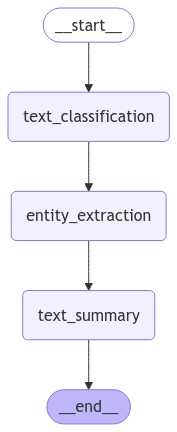

In [58]:
# View
from IPython.display import Image, display # Preview Graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
# Define a modified 'to_markdown' function that handles both strings and dictionary-like objects
def to_markdown(data) -> Markdown:
    # Check if the data is a string
    if isinstance(data, str):
        # Replace bullet points and indent for Markdown
        text = data.replace("•", "  *")
        return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

    # If the data is a dictionary-like object, format it for Markdown
    elif isinstance(data, dict):
        # Create a formatted string with keys and values
        formatted_text = ""
        for key, value in data.items():
            # Replace bullet points in values, if they are strings
            if isinstance(value, str):
                value = value.replace("•", "  *")
            # Indent keys and values for Markdown formatting
            formatted_text += f"> **{key}**:\n"
            formatted_text += textwrap.indent(str(value), ">   ") + "\n\n"

        return Markdown(formatted_text)

    # If the data is of an unsupported type, raise an error
    else:
        raise ValueError("Unsupported data type for to_markdown function")


In [70]:
# Invoke the Graph

text = """
Intelligent Agents (IA) are a fundamental concept in artificial intelligence that has gained immense popularity in various industries. An Intelligent Agent can be thought of as a software entity designed to perceive its environment and take actions that maximize its chances of successfully achieving a goal. Unlike simple automated programs, IA agents are built to learn, adapt, and operate autonomously, making them versatile and applicable to many real-world problems.

IA agents come in different forms, each with a specific set of capabilities that enable them to work effectively within their domains. One common example is the reactive agent, which bases its actions purely on the current state of its environment. This kind of agent does not store or process memories of past actions but instead reacts to changing stimuli directly. Simple rule-based bots used for navigating basic environments fall into this category.

In contrast, more sophisticated IA agents can maintain an internal state, allowing them to make decisions based not just on the present but also on past experiences. These agents are often termed deliberative agents, as they consider the implications of different choices over time to achieve their objectives. Deliberative agents use planning and optimization techniques to identify the sequence of actions that will lead to a desired outcome.

Another crucial category of IA agents is learning agents. These agents are capable of improving their behavior over time. A learning agent can modify its rules or policies based on feedback, allowing it to become more efficient in completing tasks. Machine learning algorithms, such as reinforcement learning, are often integrated into IA agents to help them learn from success or failure in their tasks. AlphaGo, a game-playing agent developed by DeepMind, is an excellent example of a learning agent that was able to outperform expert human players by continuously improving its strategies.

IA agents can also be multi-agent systems, where several agents collaborate or compete to accomplish goals. In multi-agent systems, agents can share information and coordinate their actions, leading to a collective intelligence capable of solving complex problems that would be too challenging for a single agent. For instance, self-driving cars in a smart transportation network can work together to prevent traffic congestion by communicating in real-time, adjusting their speeds, and choosing routes dynamically.
"""

In [66]:
output = graph.invoke({"text": text})

--Classification-- {'text': '\nIntelligent Agents (IA) are a fundamental concept in artificial intelligence that has gained immense popularity in various industries. An Intelligent Agent can be thought of as a software entity designed to perceive its environment and take actions that maximize its chances of successfully achieving a goal. Unlike simple automated programs, IA agents are built to learn, adapt, and operate autonomously, making them versatile and applicable to many real-world problems.\n\nIA agents come in different forms, each with a specific set of capabilities that enable them to work effectively within their domains. One common example is the reactive agent, which bases its actions purely on the current state of its environment. This kind of agent does not store or process memories of past actions but instead reacts to changing stimuli directly. Simple rule-based bots used for navigating basic environments fall into this category.\n\nIn contrast, more sophisticated IA a

In [77]:
markdown_output = to_markdown(output)  # Convert the output to Markdown format

# Display the formatted Markdown output
markdown_output



> **text**:

>   Intelligent Agents (IA) are a fundamental concept in artificial intelligence that has gained immense popularity in various industries. An Intelligent Agent can be thought of as a software entity designed to perceive its environment and take actions that maximize its chances of successfully achieving a goal. Unlike simple automated programs, IA agents are built to learn, adapt, and operate autonomously, making them versatile and applicable to many real-world problems.

>   IA agents come in different forms, each with a specific set of capabilities that enable them to work effectively within their domains. One common example is the reactive agent, which bases its actions purely on the current state of its environment. This kind of agent does not store or process memories of past actions but instead reacts to changing stimuli directly. Simple rule-based bots used for navigating basic environments fall into this category.

>   In contrast, more sophisticated IA agents can maintain an internal state, allowing them to make decisions based not just on the present but also on past experiences. These agents are often termed deliberative agents, as they consider the implications of different choices over time to achieve their objectives. Deliberative agents use planning and optimization techniques to identify the sequence of actions that will lead to a desired outcome.

>   Another crucial category of IA agents is learning agents. These agents are capable of improving their behavior over time. A learning agent can modify its rules or policies based on feedback, allowing it to become more efficient in completing tasks. Machine learning algorithms, such as reinforcement learning, are often integrated into IA agents to help them learn from success or failure in their tasks. AlphaGo, a game-playing agent developed by DeepMind, is an excellent example of a learning agent that was able to outperform expert human players by continuously improving its strategies.

>   IA agents can also be multi-agent systems, where several agents collaborate or compete to accomplish goals. In multi-agent systems, agents can share information and coordinate their actions, leading to a collective intelligence capable of solving complex problems that would be too challenging for a single agent. For instance, self-driving cars in a smart transportation network can work together to prevent traffic congestion by communicating in real-time, adjusting their speeds, and choosing routes dynamically.


> **classification**:
>   ARTICLE 


> **entities**:
>   ```json
>   {"entities": ["Intelligent Agents (IA)", "artificial intelligence", "IA agents", "reactive agent", "rule-based bots", "deliberative agents", "learning agents", "AlphaGo", "DeepMind", "multi-agent systems", "self-driving cars", "smart transportation network"]}
>   ``` 


> **summary**:
>   Intelligent Agents (IA) are software entities that perceive their environment and act to achieve goals. They are more advanced than automated programs as they can learn, adapt, and operate autonomously. IA agents come in different forms, including reactive agents that react to immediate stimuli, deliberative agents that consider past experiences, and learning agents that improve their behavior over time. Learning agents use machine learning to adapt based on feedback, exemplified by AlphaGo, which surpassed human players in Go. IA agents can also form multi-agent systems, where multiple agents collaborate or compete, like self-driving cars in a smart transportation network. These systems demonstrate the potential of IA to solve complex problems through collective intelligence. 


